In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [3]:
class Net(nn.Module):

  #Function to fetch GhostBatchNorm 
  #flag = 1 for GhostBatchNorm and flag = 0 for batchnorm2d
    def batch_norm(self,channels, flag):
          if flag == 1:
            return GhostBatchNorm(channels, num_splits=2, weight=False)
          else:
            return nn.BatchNorm2d(channels)

    def __init__(self,flag):
        super(Net, self).__init__() 

        #block1
        self.conv1 = nn.Conv2d(1, 8, 3,padding = True) #o/p size:28; rf: 3
        self.Batchnorm1 = self.batch_norm(8, flag)
        self.conv2 = nn.Conv2d(8, 15, 3) #o/p size: 26; rf: 5
        self.Batchnorm2 = self.batch_norm(15, flag)


        #transition block
        self.pool1 = nn.MaxPool2d(2, 2) #o/p size: 13; rf: 6
        self.pool1trns = nn.Conv2d(15, 10, 1)#o/p size: 13; rf: 6
        self.Batchnormtrns1 =self.batch_norm(10, flag)
        
        #block2
        self.conv3 = nn.Conv2d(10,14,3) #o/p size: 11; rf: 10
        self.Batchnorm3 = self.batch_norm(14, flag)
        self.dp3 = nn.Dropout(p = 0.10) 
        self.conv4 = nn.Conv2d(14, 16, 3) #o/p size: 9; rf: 14
        self.Batchnorm4 = self.batch_norm(16, flag)
        self.dp4 = nn.Dropout(p = 0.10)
        self.conv5 = nn.Conv2d(16, 20, 3) #o/p size: 7; rf: 18
        self.Batchnorm5 = self.batch_norm(20, flag)
        self.dp5 = nn.Dropout(p = 0.10)

        #gap and 1X1 
        self.conv6_avgp = nn.AvgPool2d(kernel_size=7) #o/p size: 1; rf: 30
        self.pool2trns = nn.Conv2d(20,10,1) #6

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.Batchnorm1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.Batchnorm2(x)


        x = self.pool1(x)
        x = self.pool1trns(x)
        x = F.relu(x)
        x = self.Batchnormtrns1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.Batchnorm3(x)
        x = self.dp3(x)
 
        x = self.conv4(x)
        x = F.relu(x)
        x = self.Batchnorm4(x)
        x = self.dp4(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.Batchnorm5(x)
        x = self.dp5(x)

        x = self.conv6_avgp(x)

        x = self.pool2trns(x)


        x = x.view(-1, 10)
        return F.log_softmax(x,dim=-1)

In [4]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_ = Net(0).to(device)
summary(model_, input_size=(1, 28, 28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 15, 26, 26]           1,095
       BatchNorm2d-4           [-1, 15, 26, 26]              30
         MaxPool2d-5           [-1, 15, 13, 13]               0
            Conv2d-6           [-1, 10, 13, 13]             160
       BatchNorm2d-7           [-1, 10, 13, 13]              20
            Conv2d-8           [-1, 14, 11, 11]           1,274
       BatchNorm2d-9           [-1, 14, 11, 11]              28
          Dropout-10           [-1, 14, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,032
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]               0
           Conv2d-14             [-1, 2

In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-8.0, 8.0), fill=(1,)),                       
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [6]:
from tqdm import tqdm
test_loss_ = []
train_loss = 0

def train(model, device, train_loader, optimizer, epoch, model_i):
    model.train()
    train_correct = 0
    l1_regularization = 0
    Lambda = 0.001
    train_loss = 0

    pbar = tqdm(train_loader,leave=False,position=0)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()

        #Changing loss function for L1 regularisation 
        if model_i in (0,2,4):
          l1_regularization = 0
          for param in model.parameters():
            l1_regularization += torch.sum(abs(param))
          train_loss = F.nll_loss(output, target) + Lambda * l1_regularization
        else:
          train_loss = F.nll_loss(output, target)
              
        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc= f'loss={train_loss.item()} batch_id={batch_idx}')
        
    print('Epoch: {:.0f},LR: {}.\nTrain set: train Average loss: {:.4f}, train_Accuracy: {}/{} ({:.4f}%)\n'.format(
        epoch,optimizer.param_groups[0]['lr'],train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss

In [7]:
from torch.optim.lr_scheduler import StepLR



In [8]:
accu = []
loss_test = []

summary(model_, input_size=(1, 28, 28))

for idx in range(0,5):
  #L1 regularization with Batch Normalization
  if idx == 0:
    print("############################## L1 regularization with Batch Normalization ##############################")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(0).to(device)
    optimizer = optim.SGD(model_.parameters(), lr=0.03, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.8)
     
  #L2 regularization with Batch Normalization
  #L1 and L2 with Batch Normalization
  if idx in (1,2):
    if idx == 1:
      print("############################## L2 regularization with Batch Normalization ##############################")
    else:
      print("L1 and L2 with Batch Normalization")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(0).to(device)   
    optimizer = optim.SGD(model_.parameters(), lr=0.03, momentum=0.9, weight_decay=0.001)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.8)

  #with GBN
  if idx == 3:
    print("############################## With GBN ##############################")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(1).to(device)  
    optimizer = optim.SGD(model_.parameters(), lr=0.03, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.8)

  #with L1 and L2 with GBN
  if idx == 4:
    print("############################## L1 and L2 regularization with GBN ##############################")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model_ = Net(1).to(device)   
    optimizer = optim.SGD(model_.parameters(), lr=0.03, momentum=0.9, weight_decay=0.001)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.8)
    

  valid_acc = []
  loss_test_ = []

  for epoch in range(1, 26):
    train(model_, device, train_loader, optimizer, epoch, idx)
    scheduler.step()
    valid_a, valid_l = test(model_, device, test_loader)
    #Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    loss_test_.append(valid_l)
  
  if idx == 3:
    # Specify a path
    PATH = "GBN_model_v2.pt"
    # Save
    torch.save(model_, PATH)
  
  accu.append(valid_acc)
  loss_test.append(loss_test_)

  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 15, 26, 26]           1,095
       BatchNorm2d-4           [-1, 15, 26, 26]              30
         MaxPool2d-5           [-1, 15, 13, 13]               0
            Conv2d-6           [-1, 10, 13, 13]             160
       BatchNorm2d-7           [-1, 10, 13, 13]              20
            Conv2d-8           [-1, 14, 11, 11]           1,274
       BatchNorm2d-9           [-1, 14, 11, 11]              28
          Dropout-10           [-1, 14, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,032
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]               0
           Conv2d-14             [-1, 2

Epoch: 1,LR: 0.03.
Train set: train Average loss: 0.4784, train_Accuracy: 54274/60000 (90.4567%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1378, Accuracy: 9633/10000 (96.3300%)



Epoch: 2,LR: 0.03.
Train set: train Average loss: 0.5819, train_Accuracy: 57914/60000 (96.5233%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1219, Accuracy: 9659/10000 (96.5900%)



Epoch: 3,LR: 0.03.
Train set: train Average loss: 0.4179, train_Accuracy: 58062/60000 (96.7700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9755/10000 (97.5500%)



Epoch: 4,LR: 0.03.
Train set: train Average loss: 0.4195, train_Accuracy: 58192/60000 (96.9867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Accuracy: 9731/10000 (97.3100%)



Epoch: 5,LR: 0.024.
Train set: train Average loss: 0.3602, train_Accuracy: 58266/60000 (97.1100%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9788/10000 (97.8800%)



Epoch: 6,LR: 0.024.
Train set: train Average loss: 0.3320, train_Accuracy: 58140/60000 (96.9000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1449, Accuracy: 9550/10000 (95.5000%)



Epoch: 7,LR: 0.024.
Train set: train Average loss: 0.3619, train_Accuracy: 58166/60000 (96.9433%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1268, Accuracy: 9600/10000 (96.0000%)



Epoch: 8,LR: 0.024.
Train set: train Average loss: 0.3478, train_Accuracy: 58180/60000 (96.9667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1799, Accuracy: 9423/10000 (94.2300%)



Epoch: 9,LR: 0.019200000000000002.
Train set: train Average loss: 0.3428, train_Accuracy: 58308/60000 (97.1800%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1164, Accuracy: 9623/10000 (96.2300%)



Epoch: 10,LR: 0.019200000000000002.
Train set: train Average loss: 0.3790, train_Accuracy: 58258/60000 (97.0967%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0852, Accuracy: 9737/10000 (97.3700%)



Epoch: 11,LR: 0.019200000000000002.
Train set: train Average loss: 0.3708, train_Accuracy: 58241/60000 (97.0683%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0961, Accuracy: 9706/10000 (97.0600%)



Epoch: 12,LR: 0.019200000000000002.
Train set: train Average loss: 0.3134, train_Accuracy: 58329/60000 (97.2150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1344, Accuracy: 9541/10000 (95.4100%)



Epoch: 13,LR: 0.015360000000000002.
Train set: train Average loss: 0.4607, train_Accuracy: 58412/60000 (97.3533%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9841/10000 (98.4100%)



Epoch: 14,LR: 0.015360000000000002.
Train set: train Average loss: 0.2680, train_Accuracy: 58370/60000 (97.2833%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1095, Accuracy: 9675/10000 (96.7500%)



Epoch: 15,LR: 0.015360000000000002.
Train set: train Average loss: 0.2977, train_Accuracy: 58350/60000 (97.2500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2403, Accuracy: 9252/10000 (92.5200%)



Epoch: 16,LR: 0.015360000000000002.
Train set: train Average loss: 0.3208, train_Accuracy: 58364/60000 (97.2733%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1766, Accuracy: 9473/10000 (94.7300%)



Epoch: 17,LR: 0.012288000000000002.
Train set: train Average loss: 0.3813, train_Accuracy: 58529/60000 (97.5483%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0969, Accuracy: 9697/10000 (96.9700%)



Epoch: 18,LR: 0.012288000000000002.
Train set: train Average loss: 0.3143, train_Accuracy: 58390/60000 (97.3167%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1281, Accuracy: 9636/10000 (96.3600%)



Epoch: 19,LR: 0.012288000000000002.
Train set: train Average loss: 0.3130, train_Accuracy: 58468/60000 (97.4467%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1157, Accuracy: 9643/10000 (96.4300%)



Epoch: 20,LR: 0.012288000000000002.
Train set: train Average loss: 0.3500, train_Accuracy: 58440/60000 (97.4000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1079, Accuracy: 9664/10000 (96.6400%)



Epoch: 21,LR: 0.009830400000000003.
Train set: train Average loss: 0.2846, train_Accuracy: 58588/60000 (97.6467%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9810/10000 (98.1000%)



Epoch: 22,LR: 0.009830400000000003.
Train set: train Average loss: 0.2931, train_Accuracy: 58534/60000 (97.5567%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9774/10000 (97.7400%)



Epoch: 23,LR: 0.009830400000000003.
Train set: train Average loss: 0.2973, train_Accuracy: 58503/60000 (97.5050%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0885, Accuracy: 9738/10000 (97.3800%)



Epoch: 24,LR: 0.009830400000000003.
Train set: train Average loss: 0.2564, train_Accuracy: 58546/60000 (97.5767%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0828, Accuracy: 9743/10000 (97.4300%)



Epoch: 25,LR: 0.007864320000000003.
Train set: train Average loss: 0.2242, train_Accuracy: 58577/60000 (97.6283%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0851, Accuracy: 9731/10000 (97.3100%)

############################## L2 regularization with Batch Normalization ##############################


Epoch: 1,LR: 0.03.
Train set: train Average loss: 0.0641, train_Accuracy: 53906/60000 (89.8433%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9819/10000 (98.1900%)



Epoch: 2,LR: 0.03.
Train set: train Average loss: 0.0759, train_Accuracy: 58647/60000 (97.7450%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9855/10000 (98.5500%)



Epoch: 3,LR: 0.03.
Train set: train Average loss: 0.0268, train_Accuracy: 58836/60000 (98.0600%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9864/10000 (98.6400%)



Epoch: 4,LR: 0.03.
Train set: train Average loss: 0.0431, train_Accuracy: 58963/60000 (98.2717%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9890/10000 (98.9000%)



Epoch: 5,LR: 0.024.
Train set: train Average loss: 0.0777, train_Accuracy: 59092/60000 (98.4867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9892/10000 (98.9200%)



Epoch: 6,LR: 0.024.
Train set: train Average loss: 0.0474, train_Accuracy: 59120/60000 (98.5333%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9870/10000 (98.7000%)



Epoch: 7,LR: 0.024.
Train set: train Average loss: 0.0626, train_Accuracy: 59111/60000 (98.5183%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9912/10000 (99.1200%)



Epoch: 8,LR: 0.024.
Train set: train Average loss: 0.0950, train_Accuracy: 59119/60000 (98.5317%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9896/10000 (98.9600%)



Epoch: 9,LR: 0.019200000000000002.
Train set: train Average loss: 0.0409, train_Accuracy: 59177/60000 (98.6283%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9903/10000 (99.0300%)



Epoch: 10,LR: 0.019200000000000002.
Train set: train Average loss: 0.0183, train_Accuracy: 59181/60000 (98.6350%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9910/10000 (99.1000%)



Epoch: 11,LR: 0.019200000000000002.
Train set: train Average loss: 0.0231, train_Accuracy: 59227/60000 (98.7117%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9901/10000 (99.0100%)



Epoch: 12,LR: 0.019200000000000002.
Train set: train Average loss: 0.0840, train_Accuracy: 59174/60000 (98.6233%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9918/10000 (99.1800%)



Epoch: 13,LR: 0.015360000000000002.
Train set: train Average loss: 0.0416, train_Accuracy: 59237/60000 (98.7283%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9856/10000 (98.5600%)



Epoch: 14,LR: 0.015360000000000002.
Train set: train Average loss: 0.0733, train_Accuracy: 59259/60000 (98.7650%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9912/10000 (99.1200%)



Epoch: 15,LR: 0.015360000000000002.
Train set: train Average loss: 0.0395, train_Accuracy: 59237/60000 (98.7283%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9907/10000 (99.0700%)



Epoch: 16,LR: 0.015360000000000002.
Train set: train Average loss: 0.0286, train_Accuracy: 59251/60000 (98.7517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9891/10000 (98.9100%)



Epoch: 17,LR: 0.012288000000000002.
Train set: train Average loss: 0.0513, train_Accuracy: 59322/60000 (98.8700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9914/10000 (99.1400%)



Epoch: 18,LR: 0.012288000000000002.
Train set: train Average loss: 0.0953, train_Accuracy: 59288/60000 (98.8133%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9926/10000 (99.2600%)



Epoch: 19,LR: 0.012288000000000002.
Train set: train Average loss: 0.0314, train_Accuracy: 59335/60000 (98.8917%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9934/10000 (99.3400%)



Epoch: 20,LR: 0.012288000000000002.
Train set: train Average loss: 0.0329, train_Accuracy: 59289/60000 (98.8150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9921/10000 (99.2100%)



Epoch: 21,LR: 0.009830400000000003.
Train set: train Average loss: 0.0570, train_Accuracy: 59311/60000 (98.8517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9913/10000 (99.1300%)



Epoch: 22,LR: 0.009830400000000003.
Train set: train Average loss: 0.0310, train_Accuracy: 59362/60000 (98.9367%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9928/10000 (99.2800%)



Epoch: 23,LR: 0.009830400000000003.
Train set: train Average loss: 0.0293, train_Accuracy: 59321/60000 (98.8683%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9928/10000 (99.2800%)



Epoch: 24,LR: 0.009830400000000003.
Train set: train Average loss: 0.0156, train_Accuracy: 59350/60000 (98.9167%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.3100%)



Epoch: 25,LR: 0.007864320000000003.
Train set: train Average loss: 0.0320, train_Accuracy: 59370/60000 (98.9500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9939/10000 (99.3900%)

L1 and L2 with Batch Normalization


Epoch: 1,LR: 0.03.
Train set: train Average loss: 0.4214, train_Accuracy: 53922/60000 (89.8700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2850, Accuracy: 9093/10000 (90.9300%)



Epoch: 2,LR: 0.03.
Train set: train Average loss: 0.5740, train_Accuracy: 57791/60000 (96.3183%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0984, Accuracy: 9747/10000 (97.4700%)



Epoch: 3,LR: 0.03.
Train set: train Average loss: 0.4272, train_Accuracy: 58036/60000 (96.7267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1084, Accuracy: 9683/10000 (96.8300%)



Epoch: 4,LR: 0.03.
Train set: train Average loss: 0.3807, train_Accuracy: 57969/60000 (96.6150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3631, Accuracy: 8835/10000 (88.3500%)



Epoch: 5,LR: 0.024.
Train set: train Average loss: 0.4358, train_Accuracy: 58124/60000 (96.8733%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2005, Accuracy: 9326/10000 (93.2600%)



Epoch: 6,LR: 0.024.
Train set: train Average loss: 0.3580, train_Accuracy: 58119/60000 (96.8650%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1921, Accuracy: 9372/10000 (93.7200%)



Epoch: 7,LR: 0.024.
Train set: train Average loss: 0.3196, train_Accuracy: 58080/60000 (96.8000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1716, Accuracy: 9456/10000 (94.5600%)



Epoch: 8,LR: 0.024.
Train set: train Average loss: 0.3533, train_Accuracy: 58163/60000 (96.9383%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2381, Accuracy: 9152/10000 (91.5200%)



Epoch: 9,LR: 0.019200000000000002.
Train set: train Average loss: 0.3661, train_Accuracy: 58226/60000 (97.0433%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1377, Accuracy: 9601/10000 (96.0100%)



Epoch: 10,LR: 0.019200000000000002.
Train set: train Average loss: 0.2996, train_Accuracy: 58177/60000 (96.9617%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9751/10000 (97.5100%)



Epoch: 11,LR: 0.019200000000000002.
Train set: train Average loss: 0.3573, train_Accuracy: 58209/60000 (97.0150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2290, Accuracy: 9293/10000 (92.9300%)



Epoch: 12,LR: 0.019200000000000002.
Train set: train Average loss: 0.3593, train_Accuracy: 58259/60000 (97.0983%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1755, Accuracy: 9451/10000 (94.5100%)



Epoch: 13,LR: 0.015360000000000002.
Train set: train Average loss: 0.2796, train_Accuracy: 58382/60000 (97.3033%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9696/10000 (96.9600%)



Epoch: 14,LR: 0.015360000000000002.
Train set: train Average loss: 0.3338, train_Accuracy: 58307/60000 (97.1783%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Accuracy: 9703/10000 (97.0300%)



Epoch: 15,LR: 0.015360000000000002.
Train set: train Average loss: 0.3307, train_Accuracy: 58240/60000 (97.0667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1471, Accuracy: 9569/10000 (95.6900%)



Epoch: 16,LR: 0.015360000000000002.
Train set: train Average loss: 0.3253, train_Accuracy: 58355/60000 (97.2583%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1559, Accuracy: 9488/10000 (94.8800%)



Epoch: 17,LR: 0.012288000000000002.
Train set: train Average loss: 0.3024, train_Accuracy: 58439/60000 (97.3983%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1084, Accuracy: 9694/10000 (96.9400%)



Epoch: 18,LR: 0.012288000000000002.
Train set: train Average loss: 0.2250, train_Accuracy: 58389/60000 (97.3150%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1557, Accuracy: 9501/10000 (95.0100%)



Epoch: 19,LR: 0.012288000000000002.
Train set: train Average loss: 0.2303, train_Accuracy: 58413/60000 (97.3550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0874, Accuracy: 9773/10000 (97.7300%)



Epoch: 20,LR: 0.012288000000000002.
Train set: train Average loss: 0.2531, train_Accuracy: 58423/60000 (97.3717%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 9710/10000 (97.1000%)



Epoch: 21,LR: 0.009830400000000003.
Train set: train Average loss: 0.2888, train_Accuracy: 58572/60000 (97.6200%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9746/10000 (97.4600%)



Epoch: 22,LR: 0.009830400000000003.
Train set: train Average loss: 0.2395, train_Accuracy: 58538/60000 (97.5633%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1840, Accuracy: 9450/10000 (94.5000%)



Epoch: 23,LR: 0.009830400000000003.
Train set: train Average loss: 0.2429, train_Accuracy: 58492/60000 (97.4867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0834, Accuracy: 9774/10000 (97.7400%)



Epoch: 24,LR: 0.009830400000000003.
Train set: train Average loss: 0.1964, train_Accuracy: 58465/60000 (97.4417%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1346, Accuracy: 9600/10000 (96.0000%)



Epoch: 25,LR: 0.007864320000000003.
Train set: train Average loss: 0.2582, train_Accuracy: 58593/60000 (97.6550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1207, Accuracy: 9643/10000 (96.4300%)

############################## With GBN ##############################


Epoch: 1,LR: 0.03.
Train set: train Average loss: 0.1874, train_Accuracy: 53724/60000 (89.5400%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9813/10000 (98.1300%)



Epoch: 2,LR: 0.03.
Train set: train Average loss: 0.0653, train_Accuracy: 58545/60000 (97.5750%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9871/10000 (98.7100%)



Epoch: 3,LR: 0.03.
Train set: train Average loss: 0.0252, train_Accuracy: 58833/60000 (98.0550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9857/10000 (98.5700%)



Epoch: 4,LR: 0.03.
Train set: train Average loss: 0.0311, train_Accuracy: 58954/60000 (98.2567%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9895/10000 (98.9500%)



Epoch: 5,LR: 0.024.
Train set: train Average loss: 0.0388, train_Accuracy: 59092/60000 (98.4867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9880/10000 (98.8000%)



Epoch: 6,LR: 0.024.
Train set: train Average loss: 0.0168, train_Accuracy: 59069/60000 (98.4483%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.1100%)



Epoch: 7,LR: 0.024.
Train set: train Average loss: 0.0225, train_Accuracy: 59132/60000 (98.5533%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9925/10000 (99.2500%)



Epoch: 8,LR: 0.024.
Train set: train Average loss: 0.0777, train_Accuracy: 59146/60000 (98.5767%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.1500%)



Epoch: 9,LR: 0.019200000000000002.
Train set: train Average loss: 0.0130, train_Accuracy: 59238/60000 (98.7300%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9920/10000 (99.2000%)



Epoch: 10,LR: 0.019200000000000002.
Train set: train Average loss: 0.0222, train_Accuracy: 59277/60000 (98.7950%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9922/10000 (99.2200%)



Epoch: 11,LR: 0.019200000000000002.
Train set: train Average loss: 0.0803, train_Accuracy: 59278/60000 (98.7967%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9931/10000 (99.3100%)



Epoch: 12,LR: 0.019200000000000002.
Train set: train Average loss: 0.0262, train_Accuracy: 59275/60000 (98.7917%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.2200%)



Epoch: 13,LR: 0.015360000000000002.
Train set: train Average loss: 0.1221, train_Accuracy: 59309/60000 (98.8483%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.2200%)



Epoch: 14,LR: 0.015360000000000002.
Train set: train Average loss: 0.0523, train_Accuracy: 59314/60000 (98.8567%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.2400%)



Epoch: 15,LR: 0.015360000000000002.
Train set: train Average loss: 0.0920, train_Accuracy: 59310/60000 (98.8500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.3600%)



Epoch: 16,LR: 0.015360000000000002.
Train set: train Average loss: 0.0253, train_Accuracy: 59318/60000 (98.8633%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.2900%)



Epoch: 17,LR: 0.012288000000000002.
Train set: train Average loss: 0.0907, train_Accuracy: 59373/60000 (98.9550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.2900%)



Epoch: 18,LR: 0.012288000000000002.
Train set: train Average loss: 0.0747, train_Accuracy: 59402/60000 (99.0033%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.3400%)



Epoch: 19,LR: 0.012288000000000002.
Train set: train Average loss: 0.0226, train_Accuracy: 59415/60000 (99.0250%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.2900%)



Epoch: 20,LR: 0.012288000000000002.
Train set: train Average loss: 0.0530, train_Accuracy: 59380/60000 (98.9667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.3100%)



Epoch: 21,LR: 0.009830400000000003.
Train set: train Average loss: 0.0204, train_Accuracy: 59439/60000 (99.0650%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.2800%)



Epoch: 22,LR: 0.009830400000000003.
Train set: train Average loss: 0.0298, train_Accuracy: 59429/60000 (99.0483%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.4100%)



Epoch: 23,LR: 0.009830400000000003.
Train set: train Average loss: 0.0377, train_Accuracy: 59421/60000 (99.0350%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.3600%)



Epoch: 24,LR: 0.009830400000000003.
Train set: train Average loss: 0.0451, train_Accuracy: 59416/60000 (99.0267%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.3900%)



Epoch: 25,LR: 0.007864320000000003.
Train set: train Average loss: 0.0515, train_Accuracy: 59471/60000 (99.1183%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.3600%)

############################## L1 and L2 regularization with GBN ##############################


Epoch: 1,LR: 0.03.
Train set: train Average loss: 0.5409, train_Accuracy: 53373/60000 (88.9550%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2282, Accuracy: 9359/10000 (93.5900%)



Epoch: 2,LR: 0.03.
Train set: train Average loss: 0.4252, train_Accuracy: 57636/60000 (96.0600%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1131, Accuracy: 9715/10000 (97.1500%)



Epoch: 3,LR: 0.03.
Train set: train Average loss: 0.4771, train_Accuracy: 57895/60000 (96.4917%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1547, Accuracy: 9577/10000 (95.7700%)



Epoch: 4,LR: 0.03.
Train set: train Average loss: 0.4386, train_Accuracy: 57961/60000 (96.6017%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1045, Accuracy: 9735/10000 (97.3500%)



Epoch: 5,LR: 0.024.
Train set: train Average loss: 0.4401, train_Accuracy: 58137/60000 (96.8950%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1066, Accuracy: 9707/10000 (97.0700%)



Epoch: 6,LR: 0.024.
Train set: train Average loss: 0.5004, train_Accuracy: 58154/60000 (96.9233%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9813/10000 (98.1300%)



Epoch: 7,LR: 0.024.
Train set: train Average loss: 0.3742, train_Accuracy: 58175/60000 (96.9583%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0893, Accuracy: 9770/10000 (97.7000%)



Epoch: 8,LR: 0.024.
Train set: train Average loss: 0.4412, train_Accuracy: 58103/60000 (96.8383%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1382, Accuracy: 9557/10000 (95.5700%)



Epoch: 9,LR: 0.019200000000000002.
Train set: train Average loss: 0.4248, train_Accuracy: 58234/60000 (97.0567%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0953, Accuracy: 9750/10000 (97.5000%)



Epoch: 10,LR: 0.019200000000000002.
Train set: train Average loss: 0.4725, train_Accuracy: 58231/60000 (97.0517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1000, Accuracy: 9760/10000 (97.6000%)



Epoch: 11,LR: 0.019200000000000002.
Train set: train Average loss: 0.3636, train_Accuracy: 58226/60000 (97.0433%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0880, Accuracy: 9771/10000 (97.7100%)



Epoch: 12,LR: 0.019200000000000002.
Train set: train Average loss: 0.3616, train_Accuracy: 58180/60000 (96.9667%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1131, Accuracy: 9686/10000 (96.8600%)



Epoch: 13,LR: 0.015360000000000002.
Train set: train Average loss: 0.4085, train_Accuracy: 58328/60000 (97.2133%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1027, Accuracy: 9752/10000 (97.5200%)



Epoch: 14,LR: 0.015360000000000002.
Train set: train Average loss: 0.3512, train_Accuracy: 58283/60000 (97.1383%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0969, Accuracy: 9747/10000 (97.4700%)



Epoch: 15,LR: 0.015360000000000002.
Train set: train Average loss: 0.3962, train_Accuracy: 58241/60000 (97.0683%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0751, Accuracy: 9817/10000 (98.1700%)



Epoch: 16,LR: 0.015360000000000002.
Train set: train Average loss: 0.3971, train_Accuracy: 58324/60000 (97.2067%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 9805/10000 (98.0500%)



Epoch: 17,LR: 0.012288000000000002.
Train set: train Average loss: 0.4149, train_Accuracy: 58428/60000 (97.3800%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0802, Accuracy: 9781/10000 (97.8100%)



Epoch: 18,LR: 0.012288000000000002.
Train set: train Average loss: 0.3705, train_Accuracy: 58380/60000 (97.3000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9853/10000 (98.5300%)



Epoch: 19,LR: 0.012288000000000002.
Train set: train Average loss: 0.3259, train_Accuracy: 58372/60000 (97.2867%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0919, Accuracy: 9734/10000 (97.3400%)



Epoch: 20,LR: 0.012288000000000002.
Train set: train Average loss: 0.3967, train_Accuracy: 58351/60000 (97.2517%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9845/10000 (98.4500%)



Epoch: 21,LR: 0.009830400000000003.
Train set: train Average loss: 0.3254, train_Accuracy: 58375/60000 (97.2917%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0893, Accuracy: 9750/10000 (97.5000%)



Epoch: 22,LR: 0.009830400000000003.
Train set: train Average loss: 0.3408, train_Accuracy: 58410/60000 (97.3500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9853/10000 (98.5300%)



Epoch: 23,LR: 0.009830400000000003.
Train set: train Average loss: 0.3273, train_Accuracy: 58448/60000 (97.4133%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9834/10000 (98.3400%)



Epoch: 24,LR: 0.009830400000000003.
Train set: train Average loss: 0.3362, train_Accuracy: 58427/60000 (97.3783%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9776/10000 (97.7600%)



Epoch: 25,LR: 0.007864320000000003.
Train set: train Average loss: 0.3569, train_Accuracy: 58490/60000 (97.4833%)




Test set: Average loss: 0.0653, Accuracy: 9825/10000 (98.2500%)



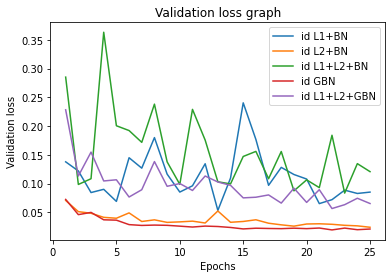

In [17]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = loss_test
Modelgraph = ['L1+BN','L2+BN','L1+L2+BN','GBN','L1+L2+GBN']

plt.title("Validation loss graph")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
#plt.figure(figsize=(10,10))

for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
#plt.show()
plt.savefig('Validation loss graph')

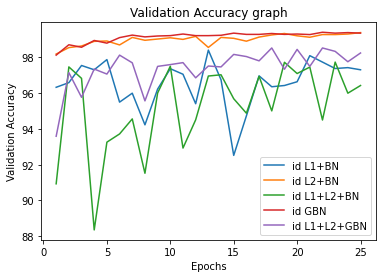

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = accu
Modelgraph = ['L1+BN','L2+BN','L1+L2+BN','GBN','L1+L2+GBN']


plt.title("Validation Accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")


for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
plt.show()
plt.savefig('Validation Accuracy graph_')

In [18]:
# Load
model = torch.load(PATH)
model.eval()

tot = 0
data_ = []
target_ = []
pred_ = []
correct = 0
tot_correct = 0
indx = []

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  correct += pred.eq(target.view_as(pred)).sum().item()
  equals = pred.eq(target.view_as(pred)).tolist()
    
  for idx in range(0,len(equals)):
    if equals[idx] == [False]:
      indx.append(idx)
      data_.append(data[idx])
      target_.append(target[idx])
      pred_.append(pred[idx])


  if len(indx) > 25:
    break
     

In [19]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(15,4), rows=2, interp=False,titles = None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None:
            sp.set_title( titles[i].tolist(), fontsize=14)

        sp.axis('Off')
        plt.imshow((torch.squeeze(ims[i]).tolist()))
        


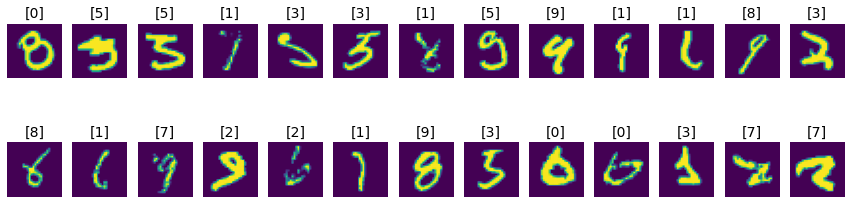

In [20]:
plots(data_,titles = pred_)
